# RGB to Grayscale
## Code logic:
- Essentially, read in mask only image (not composite) and figure out unique tuples that represent singular RGB values.
- A typical RBG value to produce a color value can be broken up into (R, G, B) insity values.
- Tuples are preferable over numpy arrays as they can be easily condensed into unique elemnts using a set and then
converted back into a list (they are hashable).
- After uniques are found, build a dictionary with values from 1 to number of unique RGB values in the images.
These will become the grayscale int values that we then plot.
The resulting array should automatically upscale from 8-bit integer if needed (>256 unique elements).
- **This only works for mask images, NOT overlays!**


In [1]:
# Imports

import tifffile
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [2]:
# Read in the file

mask_rgb = tifffile.imread(r'sample_data\N_photons_day22_feat2_Object Predictions_cyto.tiff')

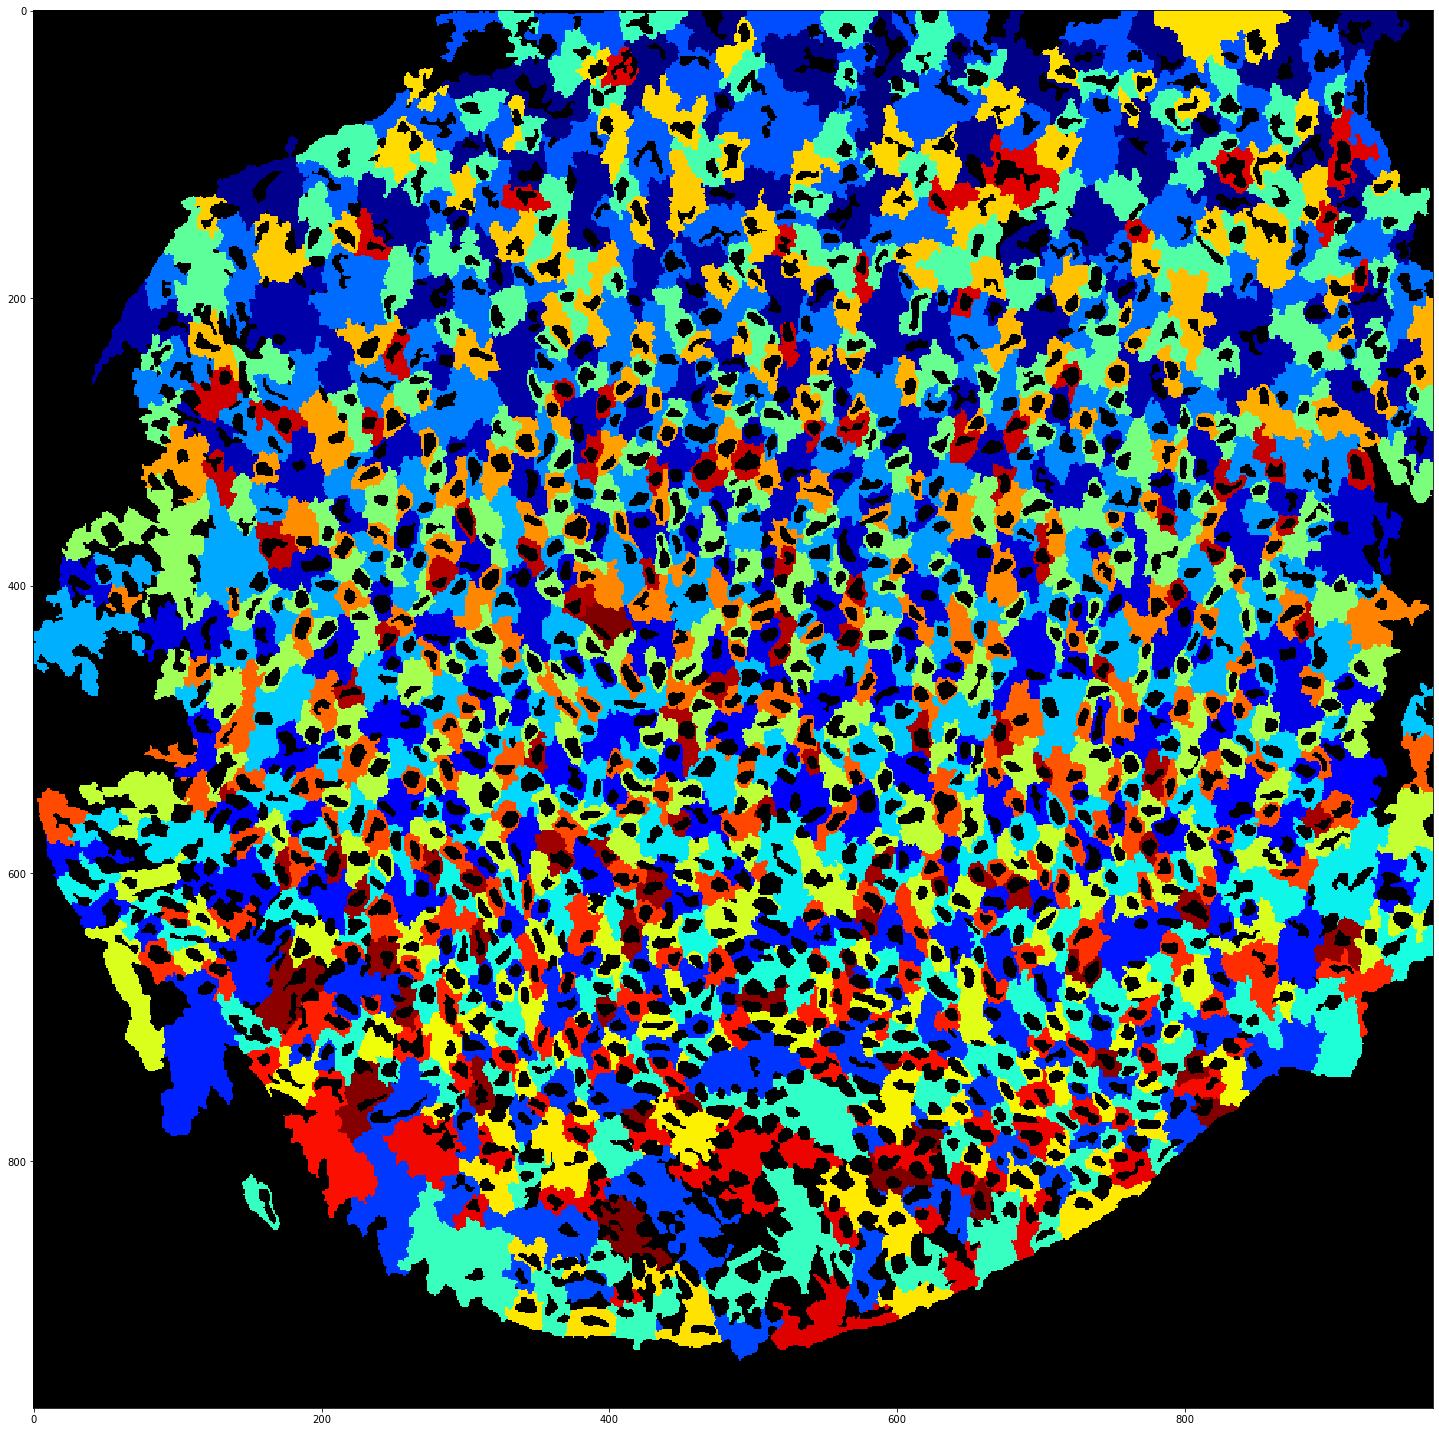

In [3]:
def generate_figure(image, cmap = plt.cm.Greys_r):
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.imshow(image, interpolation = 'nearest', cmap = cmap)
    fig.tight_layout()

generate_figure(mask_rgb)

In [4]:
# Iterate over every row and column in the mask image and generate a list of RGB tuples
# There are probably more efficient ways to do this with np.reshape/np.squeeze, but for readability this was used:
#     - if you are dealing with a larger image set, adjust as needed for a more efficient solution
# Creating a set initially and having to check every time we add a new element for whether it is unique is inefficient

tuple_list = list()
for row in mask_rgb:
    for column in row:
        tuple_list.append(tuple(column))

# Convert from list -> set -> list to only keep unique RGB values for lookup table
# Benefit of the tuple shows here! Hashable in a set which a numpy array alone wouldn't be

tuple_list= list(set(tuple_list))

# Make a dictionary of RGB tuples to int index from 1 to length of unique RGB tuples
# Add one to reserve 0 for (0,0,0) and update (0,0,0) at the end to be 0

tuple_dict = {tuple_list[i]:i+1 for i in range(len(tuple_list))}
tuple_dict[(0,0,0)] = 0

# Generate a numpy of colors and IDs.
#   - The colors array will be n x 3 depending on the number of unique RGB values
#   - The color_ids array will be n x 1 representing each of the new values for any given RGB value
#   - This creates effectively a lookup table for converting a list of RGB values to a grayscale int equivalent

colors = np.array(list(tuple_dict.keys()))
color_ids = np.array(list(tuple_dict.values()))

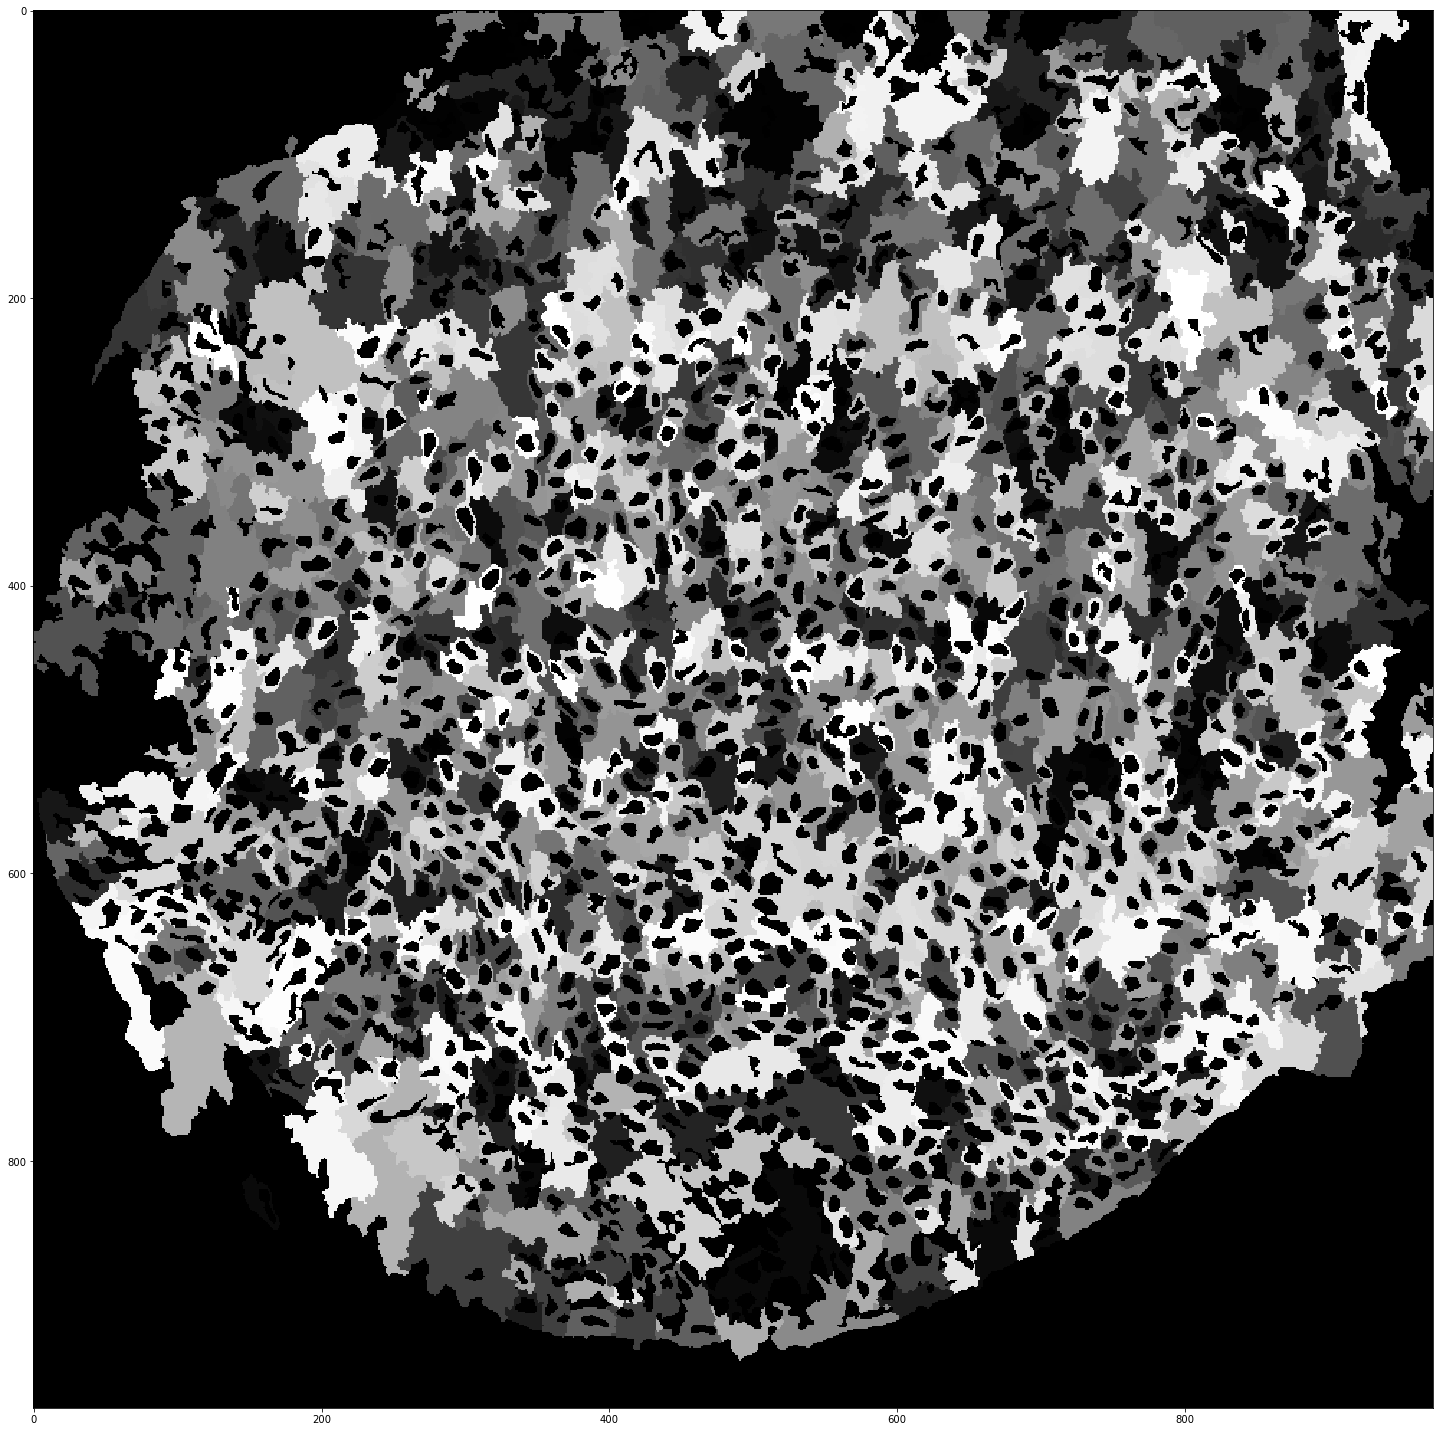

In [5]:
# Always prefer 8bit int if we can get away with it for easier viewing in windows platforms.
#   - If there are more than 255 distinct values, then use np.uint32 as that is always positive
#   and guarantees compatibility with even transparency based RGB codes (#AARRGGBB)

if len(tuple_dict) < 255:
    dtype = np.uint8
else:
    dtype = np.uint32

# Initialize output array as the shape of the original image (minus RGB channels) and set everything to 0 initially
# Also auto update dtype to be uint8 if possible, otherwise uint32

result = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype = dtype)

# Finally, check color of individual pixels in original mask against the color lookup table.
# If all 3 RGB values match, then the index and new label of that point are returned

label, row, column = np.where((mask_rgb == colors[:, None, None, :]).all(axis = 3))

# Index rows and columns to now be the color ID determined above
# Length of each of these will be mask.shape[0]*mask.shape[1], and will be automatically reshaped to fit the result array

result[row, column] = color_ids[label]

# Display a figure of the resulting image

generate_figure(result)

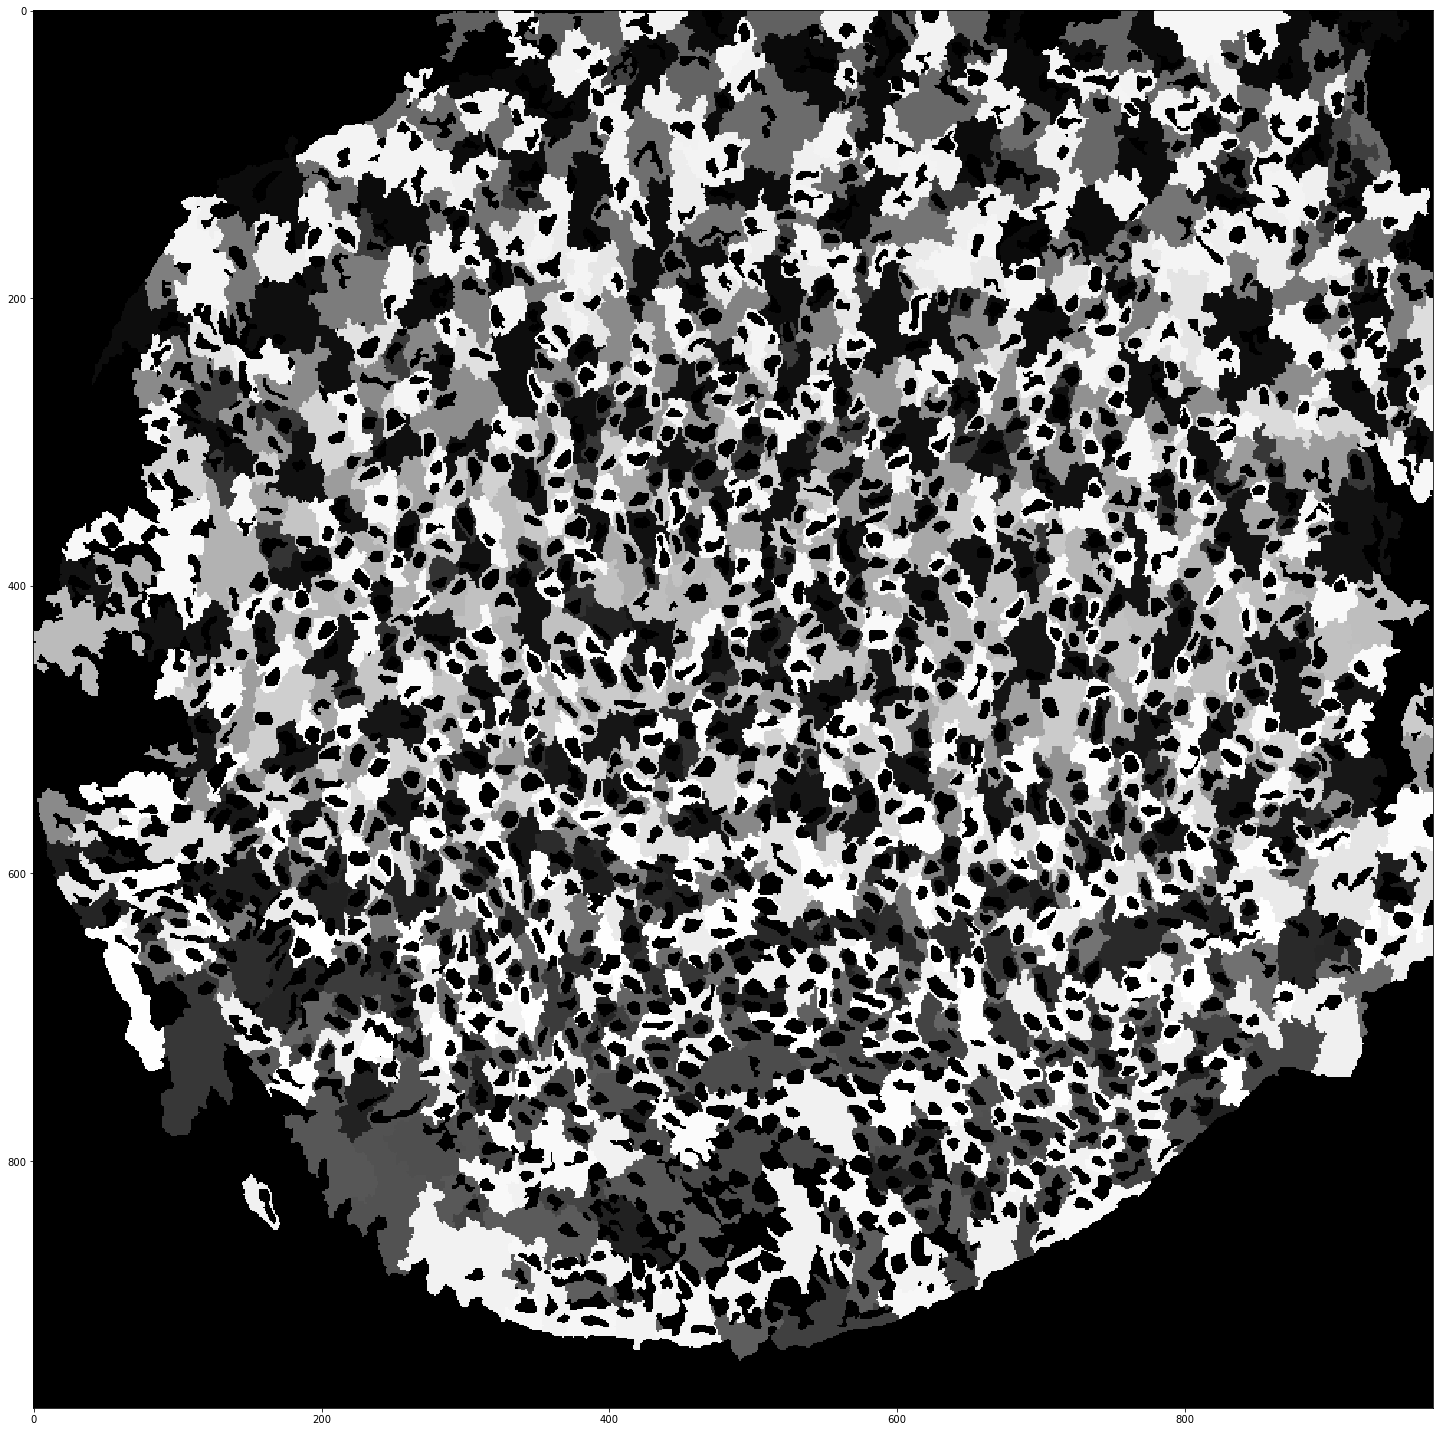

In [6]:
# Can also use the skimage.color rgb2gray function as well with different results

og_grayscale = rgb2gray(mask_rgb)

generate_figure(og_grayscale)

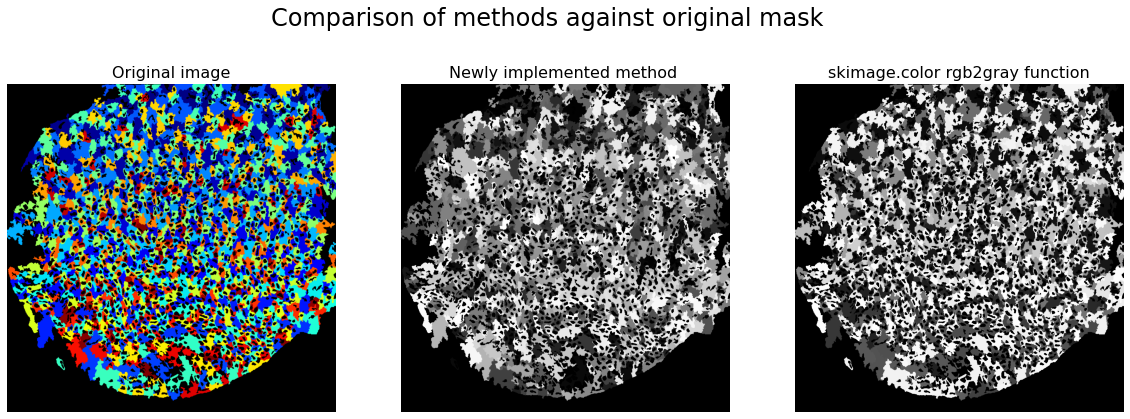

In [8]:
# Generate comparison image of original mask, new method, and skimage rgb2gray function

fig, ax = plt.subplots(1,3)
fig.suptitle('Comparison of methods against original mask', fontsize = 24)
fig.set_figheight(7)
fig.set_figwidth(20)
ax[0].imshow(mask_rgb, cmap = plt.cm.Greys_r)
ax[0].set_title('Original image', fontsize = 16)
ax[0].axis('off')
ax[1].imshow(result, cmap = plt.cm.Greys_r)
ax[1].set_title('Newly implemented method ', fontsize = 16)
ax[1].axis('off')
ax[2].imshow(og_grayscale, cmap = plt.cm.Greys_r)
ax[2].set_title('skimage.color rgb2gray function', fontsize = 16)
ax[2].axis('off')

fig.savefig('comparison.png')

In [ ]:
# Write the file as a Tiff if desired

tifffile.imwrite('demo_output.tiff', result)
